In [92]:
%pip install pandas numpy statsmodels scipy pmdarima matplotlib seaborn

In [93]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

Importing the data


In [94]:
#importing sales and ingredients data
sales_data=pd.read_csv("Pizza_Sale - pizza_sales.csv")
ingredients_data=pd.read_csv("Pizza_ingredients - Pizza_ingredients.csv")


In [95]:
sales_data.shape #size of the dataset

(48620, 12)

In [96]:
#first 5 rows of sales_data
sales_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [97]:
#finding missing values
sales_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


In [98]:
#finding duplicate values
print(sales_data.duplicated().sum())


0


In [99]:
sales_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


In [100]:
sales_data.info() #information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


Ingredients dataset

In [101]:
ingredients_data.head() #first 5 rows of data

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [102]:
ingredients_data.shape #size of the dataset

(518, 4)

In [103]:
ingredients_data.isnull().sum() #finding missing values


,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,4


In [104]:
#finding duplicate values
print(ingredients_data.duplicated().sum())

0


In [105]:
  ingredients_data.info() #information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [106]:
ingredients_data.describe() #summary statistics

,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


Handling missing values in sales_dataset

In [107]:
sales_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


In [108]:
missing_total_price = sales_data[sales_data['total_price'].isna()]
missing_total_price


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
781,782,341,bbq_ckn_m,1,6/1/2015,15:35:47,16.75,NaN,M,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza
782,783,341,pepperoni_s,1,6/1/2015,15:35:47,9.75,NaN,S,Classic,"Mozzarella Cheese, Pepperoni",The Pepperoni Pizza
783,784,342,sicilian_l,1,6/1/2015,15:44:12,20.25,NaN,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza
784,785,342,southw_ckn_l,1,6/1/2015,15:44:12,20.75,NaN,L,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja...",The Southwest Chicken Pizza
785,786,343,five_cheese_l,1,6/1/2015,15:45:37,18.50,NaN,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
786,787,343,four_cheese_m,1,6/1/2015,15:45:37,14.75,NaN,M,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
787,788,344,ital_cpcllo_m,1,6/1/2015,16:01:11,16.00,NaN,M,Classic,"Capocollo, Red Peppers, Tomatoes, Goat Cheese,...",The Italian Capocollo Pizza


In [109]:
#Filling missing total price based on quantity
sales_data['total_price'].fillna(sales_data['quantity'] * sales_data['unit_price'], inplace=True)


In [110]:
missing_pizza_category = sales_data[sales_data['pizza_category'].isna()]
missing_pizza_category

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,3/1/2015,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,3/1/2015,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,3/1/2015,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,3/1/2015,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,3/1/2015,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
431,432,183,spin_pesto_s,1,3/1/2015,18:54:55,12.50,12.50,S,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
432,433,184,hawaiian_l,1,3/1/2015,18:59:05,16.50,16.50,L,NaN,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
433,434,185,sicilian_m,1,3/1/2015,19:08:33,16.25,16.25,M,NaN,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza
434,435,185,spin_pesto_s,1,3/1/2015,19:08:33,12.50,12.50,S,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
435,436,186,mexicana_l,1,3/1/2015,19:36:00,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [111]:
#Fillimg missing pizza category based on pizza name id
category_mapping = sales_data[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

sales_data['pizza_category'] = sales_data['pizza_category'].fillna(sales_data['pizza_name_id'].map(category_mapping))

In [112]:
#Filling missing pizza ingredients based on pizza name
missing_pizza_ingredients=sales_data[sales_data["pizza_ingredients"].isna()]
missing_pizza_ingredients

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,4/1/2015,22:22:13,18.50,18.50,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,5/1/2015,11:23:35,18.50,18.50,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,5/1/2015,11:23:35,16.00,16.00,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,5/1/2015,11:23:35,16.50,16.50,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,5/1/2015,11:23:35,16.00,16.00,M,Veggie,NaN,The Spinach and Feta Pizza
585,586,256,pep_msh_pep_l,1,5/1/2015,11:56:06,17.50,17.50,L,Classic,NaN,"The Pepperoni, Mushroom, and Peppers Pizza"
586,587,257,cali_ckn_l,1,5/1/2015,11:59:04,20.75,20.75,L,Chicken,NaN,The California Chicken Pizza
630,631,277,four_cheese_m,1,5/1/2015,15:41:50,14.75,14.75,M,Veggie,NaN,The Four Cheese Pizza
631,632,278,ital_veggie_m,1,5/1/2015,15:49:21,16.75,16.75,M,Veggie,NaN,The Italian Vegetables Pizza
632,633,278,southw_ckn_l,1,5/1/2015,15:49:21,20.75,20.75,L,Chicken,NaN,The Southwest Chicken Pizza


In [113]:
ingredients_mapping = sales_data[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

sales_data['pizza_ingredients'] = sales_data['pizza_ingredients'].fillna(sales_data['pizza_name'].map(ingredients_mapping))

In [114]:
#Filling missing pizza name from pizza ingredients
missing_pizza_name=sales_data[sales_data["pizza_name"].isna()]
missing_pizza_name

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,5/1/2015,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,5/1/2015,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,5/1/2015,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,5/1/2015,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,5/1/2015,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,5/1/2015,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,5/1/2015,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [115]:
len(sales_data['pizza_ingredients'].value_counts())

32

In [116]:
ingredients_name_mapping = sales_data[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

sales_data['pizza_name'] = sales_data['pizza_name'].fillna(sales_data['pizza_ingredients'].map(ingredients_name_mapping))

In [117]:
#Filling missing pizza name id from pizza name
name_id_mapping = sales_data[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

sales_data['pizza_name_id'] = sales_data['pizza_name_id'].fillna(sales_data['pizza_name'].map(name_id_mapping))

In [118]:
#checking null values after cleaning
sales_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [119]:
sales_data_cleaned=sales_data.to_csv("sales_data_cleaned.csv",index=False)

Handling missing values in ingredients data


In [120]:
ingredients_data.isnull().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,4


In [121]:

ingredients_data['Items_Qty_In_Grams'].fillna(ingredients_data['Items_Qty_In_Grams'].mean(), inplace=True)


In [122]:
ingredients_data.isnull().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,0


In [123]:
ingredients_data_cleaned=ingredients_data.to_csv("ingredients_data_cleaned.csv",index=False)

In [124]:
#Merging sales and ingredient data frame
merged_data = pd.merge(sales_data, ingredients_data, on='pizza_name_id', how='left')
merged_data.head()


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,30.564202
1,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.000000
2,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.000000
3,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.000000
4,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.000000


In [125]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [126]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [127]:
merged_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [128]:
merged_data.duplicated().sum()

80204

In [129]:
#removing duplicated rows
merged_data.drop_duplicates(inplace=True)
print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [130]:

sales_data_cleaned = sales_data.dropna(subset=['pizza_name_id'])

# Processing datetime features
sales_data_cleaned['order_datetime'] = pd.to_datetime(
    sales_data_cleaned['order_date'] + ' ' + sales_data_cleaned['order_time'],
    errors='coerce'
)

# Extract day, week, month, and year from the datetime column
sales_data_cleaned['order_day'] = sales_data_cleaned['order_datetime'].dt.day
sales_data_cleaned['order_week'] = sales_data_cleaned['order_datetime'].dt.isocalendar().week
sales_data_cleaned['order_month'] = sales_data_cleaned['order_datetime'].dt.month
sales_data_cleaned['order_year'] = sales_data_cleaned['order_datetime'].dt.year

sales_data_cleaned.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,order_day,order_week,order_month,order_year
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36,1.0,1,1.0,2015.0
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0


EXPLORATORY DATA ANALYSIS

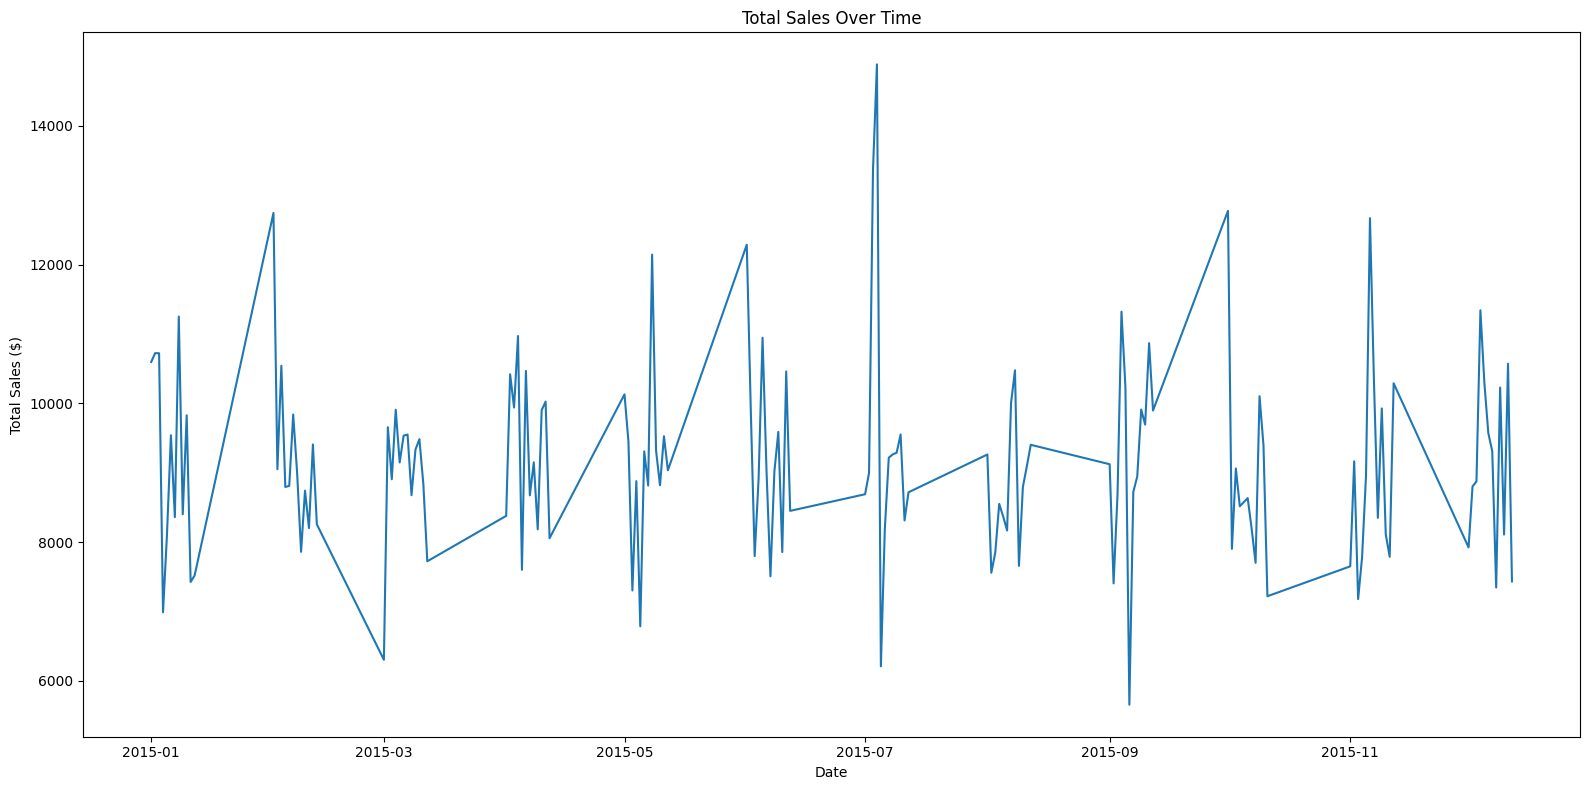

In [131]:
#Plotting total sales over time

# Group total sales by order_date
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

# Convert order_date to datetime
sales_over_time['order_date'] = pd.to_datetime(sales_over_time['order_date'], dayfirst=True, errors='coerce')

# Drop invalid dates and sort the data by date
sales_over_time = sales_over_time.dropna(subset=['order_date']).sort_values('order_date')

# Plot the graph
plt.figure(figsize=(16, 8))  # Larger graph size
plt.plot(sales_over_time['order_date'], sales_over_time['total_price'])
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.tight_layout()
plt.show()


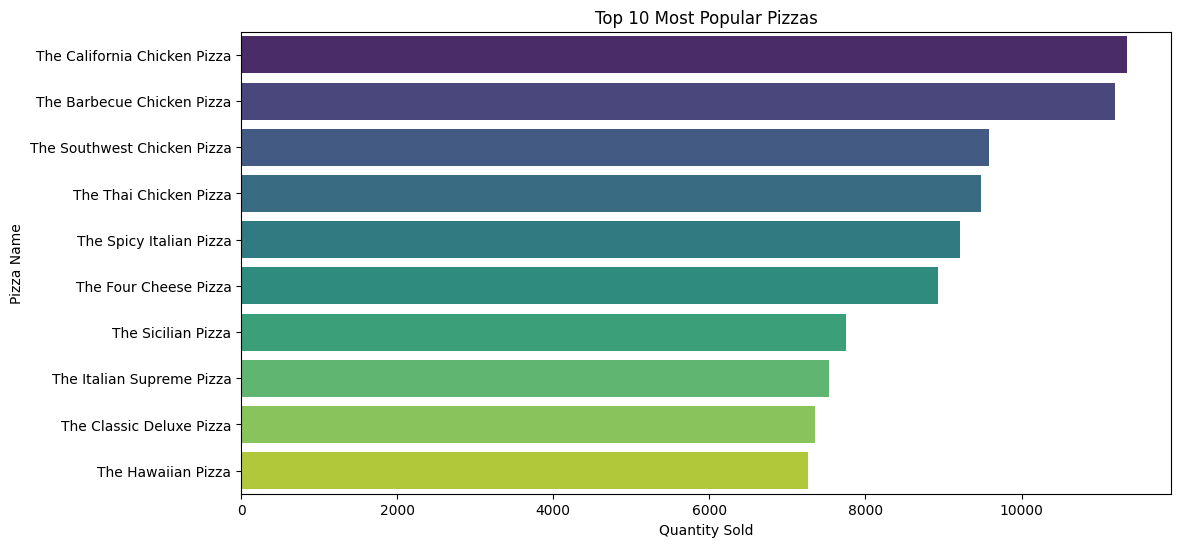

In [132]:
#Top selling pizzas
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

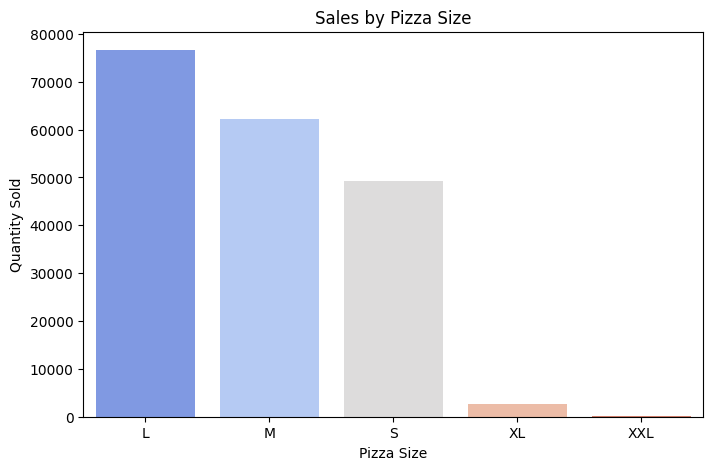

In [133]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

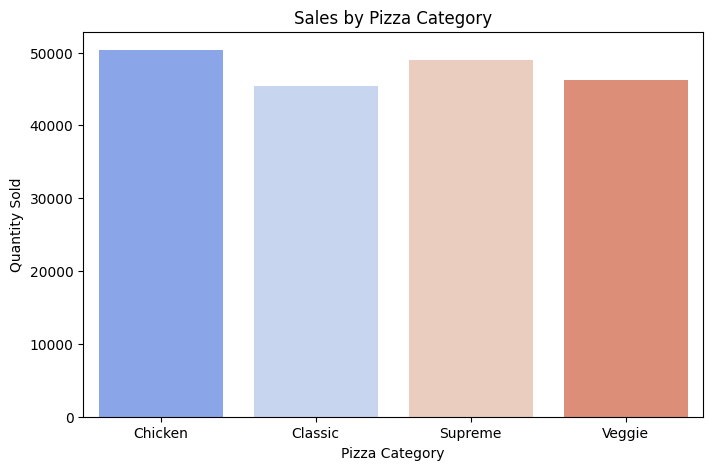

In [134]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

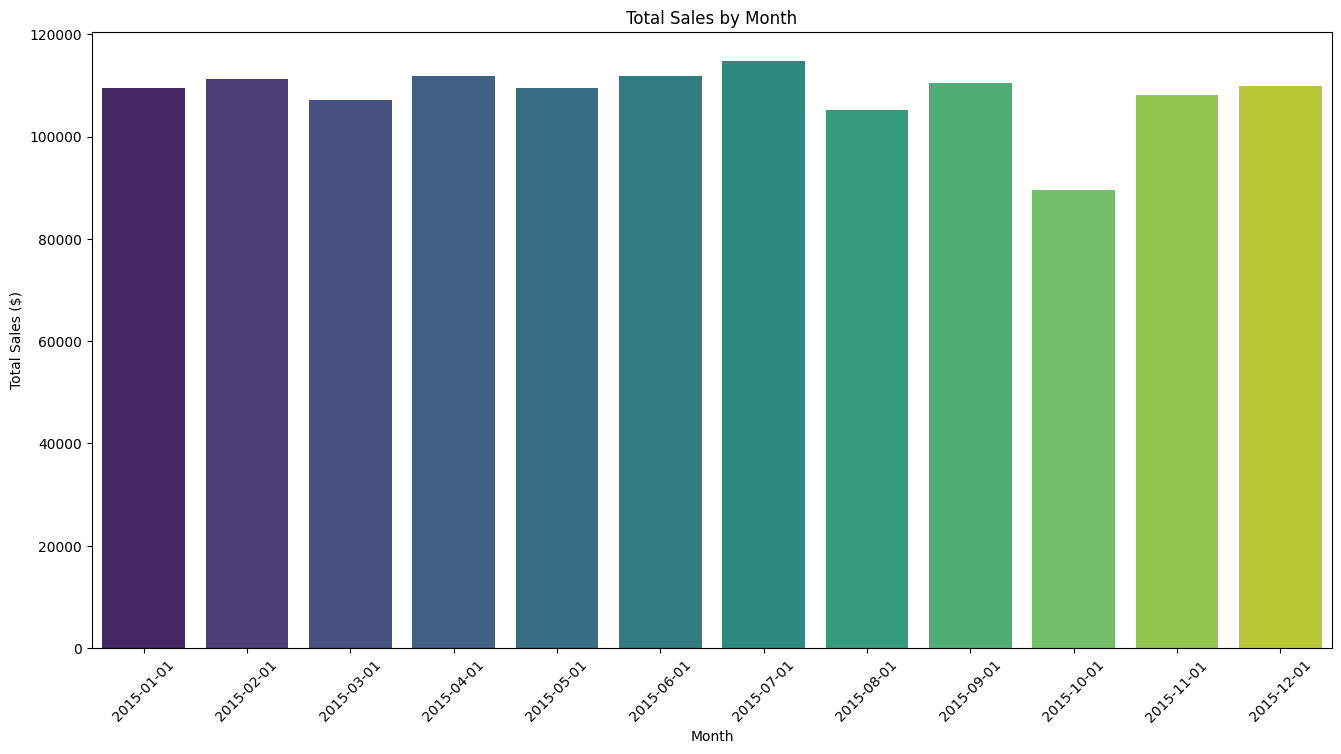

In [135]:
sales_by_month = merged_data.groupby(pd.to_datetime(merged_data['order_date'], dayfirst=True, errors='coerce').dt.to_period('M'))['total_price'].sum().reset_index()

# Convert the month period to a datetime object for plotting
sales_by_month['order_date'] = sales_by_month['order_date'].dt.to_timestamp()

# Plotting total sales by month
plt.figure(figsize=(16, 8))
# Use sns.barplot instead of plt.barplot
sns.barplot(x='order_date', y='total_price', data=sales_by_month,palette="viridis")
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.show()

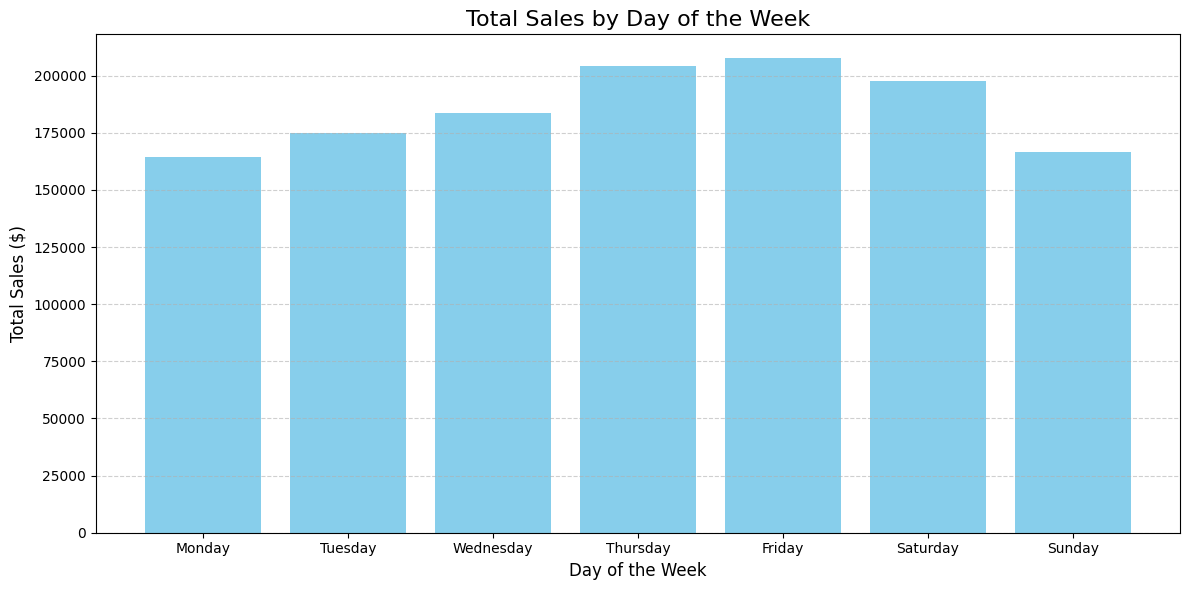

In [136]:

# Convert order_date to datetime and extract day of the week
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'], dayfirst=True, errors='coerce')
merged_data['day_of_week'] = merged_data['order_date'].dt.day_name()

# Group total sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

# Plotting total sales by day of the week
plt.figure(figsize=(12, 6))
plt.bar(sales_by_day['day_of_week'], sales_by_day['total_price'], color='skyblue')
plt.title('Total Sales by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


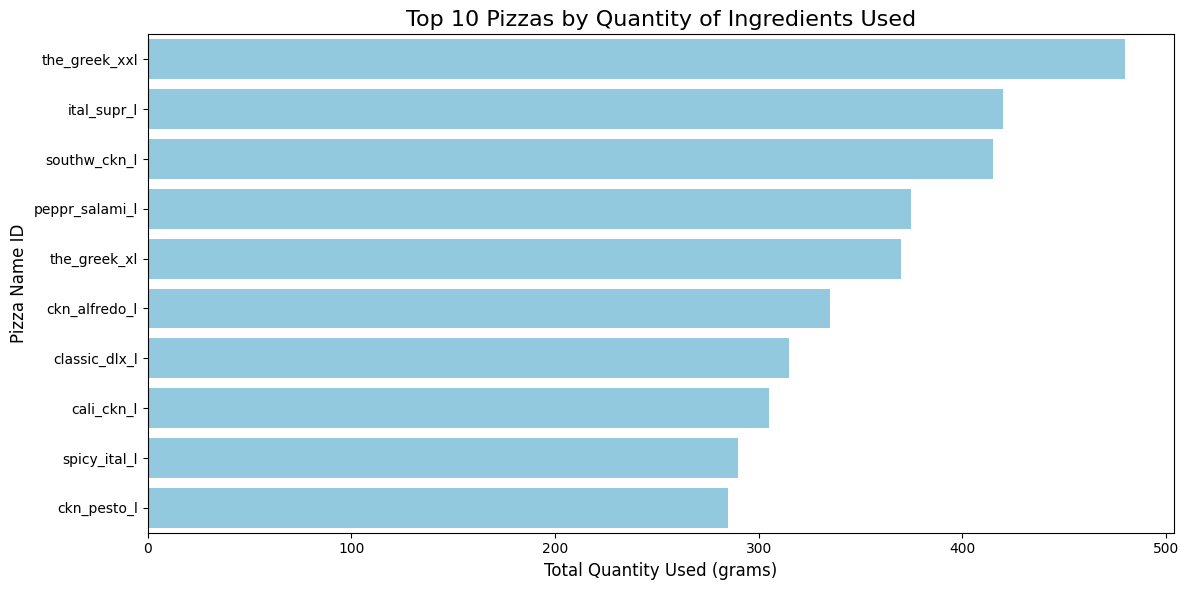

In [137]:


# Aggregate total ingredients used per pizza
total_ingredients_per_pizza = ingredients_data.groupby('pizza_name_id')['Items_Qty_In_Grams'].sum().reset_index()

# Sort by total quantity used
total_ingredients_per_pizza = total_ingredients_per_pizza.sort_values(by='Items_Qty_In_Grams', ascending=False)

# Limit to top 10 pizzas
top_pizzas = total_ingredients_per_pizza.head(10)

# Plotting a horizontal bar graph for the top 10 pizzas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_pizzas,
    y='pizza_name_id',
    x='Items_Qty_In_Grams',
    color='skyblue'
)
plt.title('Top 10 Pizzas by Quantity of Ingredients Used', fontsize=16)
plt.xlabel('Total Quantity Used (grams)', fontsize=12)
plt.ylabel('Pizza Name ID', fontsize=12)
plt.tight_layout()
plt.show()


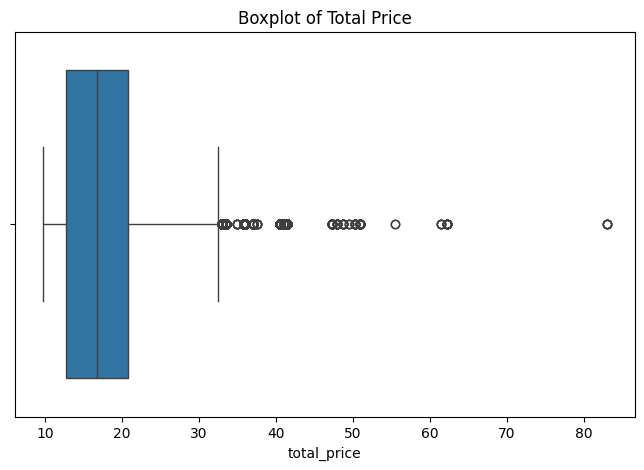

In [138]:
#Outlier detection in price
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

In [139]:
#Removing outliers in price
# Calculate the Interquartile Range (IQR) for total_price in sales_data_cleaned
Q1 = sales_data_cleaned['total_price'].quantile(0.25)  # First quartile (25th percentile)
Q3 = sales_data_cleaned['total_price'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from sales_data_cleaned
filtered_sales_data = sales_data_cleaned[
    (sales_data_cleaned['total_price'] >= lower_bound) &
    (sales_data_cleaned['total_price'] <= upper_bound)
]

# Print dataset size before and after filtering
print(f"Original Data Size: {sales_data_cleaned.shape}")
print(f"Filtered Data Size: {filtered_sales_data.shape}")

# Display the first few rows of the filtered dataset
filtered_sales_data.head()


Original Data Size: (48620, 17)
Filtered Data Size: (48007, 17)


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_datetime,order_day,order_week,order_month,order_year
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015-01-01 11:38:36,1.0,1,1.0,2015.0
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015-01-01 11:57:40,1.0,1,1.0,2015.0


In [140]:
#saving the file to csv
filtered_sales_data.to_csv("filtered_sales_data.csv", index=False)

In [141]:
# Convert order_date to datetime format
filtered_sales_data['order_date'] = pd.to_datetime(filtered_sales_data['order_date'], dayfirst=True, errors='coerce')
# Aggregate sales data by date
daily_sales = filtered_sales_data.groupby('order_date')['quantity'].sum().reset_index()


In [142]:
# Feature Engineering
daily_sales['day_of_week'] = daily_sales['order_date'].dt.dayofweek
daily_sales['day_of_year'] = daily_sales['order_date'].dt.dayofyear
daily_sales['week_of_year'] = daily_sales['order_date'].dt.isocalendar().week
daily_sales['month'] = daily_sales['order_date'].dt.month

In [143]:
# Prepare the data for regression
X = daily_sales[['day_of_week', 'day_of_year', 'week_of_year', 'month']]
y = daily_sales['quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Linear Regression model


In [144]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [145]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_predictions = regression_model.predict(X_test)
regression_mape = mean_absolute_percentage_error(y_test, regression_predictions)
regression_mse = mean_squared_error(y_test, regression_predictions)
regression_mae = mean_absolute_error(y_test, regression_predictions)
regression_r2 = r2_score(y_test, regression_predictions)
regression_rmse = np.sqrt(regression_mse)
print(f"Linear Regression MAPE: {regression_mape}")
print(f"Linear Regression MSE: {regression_mse}")
print(f"Linear Regression MAE: {regression_mae}")
print(f"Linear Regression R2: {regression_r2}")
print(f"Linear Regression RMSE: {regression_rmse}")

Linear Regression MAPE: 0.12219977709889493
Linear Regression MSE: 343.5015945414399
Linear Regression MAE: 16.30734680928575
Linear Regression R2: -0.02225382174323398
Linear Regression RMSE: 18.53379601003097


Arima Model

In [146]:
arima_model = sm.tsa.ARIMA(y_train, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_predictions = arima_result.forecast(steps=len(y_test))
arima_mape = mean_absolute_percentage_error(y_test, arima_predictions)
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_r2 = r2_score(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
print(f"ARIMA MAPE: {arima_mape}")
print(f"ARIMA MSE: {arima_mse}")
print(f"ARIMA MAE: {arima_mae}")
print(f"ARIMA R2: {arima_r2}")
print(f"ARIMA RMSE: {arima_rmse}")


ARIMA MAPE: 0.1192438772251216
ARIMA MSE: 346.463198295164
ARIMA MAE: 16.016203675688303
ARIMA R2: -0.031067494820283592
ARIMA RMSE: 18.6135219207748


Sarima Model

In [147]:
sarima_model = sm.tsa.SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_predictions = sarima_result.forecast(steps=len(y_test))
sarima_mape = mean_absolute_percentage_error(y_test, sarima_predictions)
sarima_mse = mean_squared_error(y_test, sarima_predictions)
sarima_mae = mean_absolute_error(y_test, sarima_predictions)
sarima_r2 = r2_score(y_test, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
print(f"SARIMA MAPE: {sarima_mape}")
print(f"SARIMA MSE: {sarima_mse}")
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA R2: {sarima_r2}")
print(f"SARIMA RMSE: {sarima_rmse}")

SARIMA MAPE: 0.12359994947345364
SARIMA MSE: 386.8072941097198
SARIMA MAE: 16.502233140634203
SARIMA R2: -0.151130710789517
SARIMA RMSE: 19.667417067569392


In [148]:
# Scale the features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

LSTM


In [149]:
import numpy as np

# Function to create sequences for LSTM
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Define sequence length
sequence_length = 5

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print("Training input shape:", X_train_seq.shape)
print("Testing input shape:", X_test_seq.shape)


Training input shape: (108, 5, 4)
Testing input shape: (24, 5, 4)


In [150]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train_seq.shape[2])),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')



In [151]:
# Train the LSTM model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - loss: 0.1552 - val_loss: 0.0817
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0923 - val_loss: 0.0239
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0618 - val_loss: 0.0352
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290 - val_loss: 0.1002
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342 - val_loss: 0.1016
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0354 - val_loss: 0.0736
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0269 - val_loss: 0.0483
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0294 - val_loss: 0.0381
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - val_loss: 0.0350
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0329 - val_loss: 0.0367
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250 - val_loss: 0.0343
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0310 - val_loss: 0.0332
Epoch 13/50

In [152]:
# Make predictions
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse transform the predictions and actual values to original scale
y_train_pred_original = target_scaler.inverse_transform(y_train_pred)
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_train_original = target_scaler.inverse_transform(y_train_seq)
y_test_original = target_scaler.inverse_transform(y_test_seq)

# Evaluate the model using MAPE
from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred_original)
test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original)

print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")


lstm_mape = test_mape


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Train MAPE: 0.10688226156510489
Test MAPE: 0.13241929393583837


In [153]:
# Choose the best model based on MAPE
mape_results = [
    (regression_mape, 'Linear Regression'),
    (arima_mape, 'ARIMA'),
    (sarima_mape, 'SARIMA'),
    (lstm_mape, 'LSTM'),

]

best_model = min(mape_results)
print(f"Best Model: {best_model[1]} with MAPE: {best_model[0]}")

Best Model: ARIMA with MAPE: 0.1192438772251216


Sales Forecasting for the next week using the best model

In [154]:

from datetime import timedelta

# Ensure the daily_sales index is datetime
daily_sales.index = pd.to_datetime(daily_sales.index)

# Get the last date in the daily_sales index
last_date = daily_sales.index[-1]  # This is now a Timestamp

# Generate forecast dates for the next 7 days
forecast_steps = 7
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps)

# Fit the ARIMA model to your data
arima_results = arima_model.fit()  # Fit the ARIMA model

# Use .forecast() to predict for the next 7 days
forecast = arima_results.forecast(steps=forecast_steps)

# Extract confidence intervals for the forecast
forecast_with_ci = arima_results.get_forecast(steps=forecast_steps)
confidence_intervals = forecast_with_ci.conf_int()

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Sales': forecast.values,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
})

print(forecast_df)


                             Date  Forecasted Sales   Lower CI    Upper CI
113 1970-01-02 00:00:00.000000141        145.292920  99.633850  190.951990
114 1970-01-03 00:00:00.000000141        138.861372  91.655258  186.067486
115 1970-01-04 00:00:00.000000141        134.196202  86.628070  181.764333
116 1970-01-05 00:00:00.000000141        133.817290  85.375001  182.259579
117 1970-01-06 00:00:00.000000141        135.262969  84.801342  185.724596
118 1970-01-07 00:00:00.000000141        137.591864  83.989907  191.193821
119 1970-01-08 00:00:00.000000141        137.145345  81.485594  192.805096


Purchase order(Weekly requirements)

In [155]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Assuming 'filtered_sales_data' contains the historical sales data
# Ensure 'order_date' is datetime
filtered_sales_data['order_date'] = pd.to_datetime(filtered_sales_data['order_date'])

# Group data by pizza_name_id and date to get daily totals
daily_pizza_sales = filtered_sales_data.groupby(['pizza_name_id', 'order_date'])['quantity'].sum().reset_index()

# Prepare a DataFrame to store the results
weekly_forecast = []

# Forecast for each pizza type
forecast_steps = 7  # Next week
unique_pizzas = daily_pizza_sales['pizza_name_id'].unique()

for pizza in unique_pizzas:
    # Filter data for the specific pizza
    pizza_data = daily_pizza_sales[daily_pizza_sales['pizza_name_id'] == pizza]

    # Create a daily time series
    pizza_time_series = pizza_data.set_index('order_date')['quantity'].asfreq('D', fill_value=0)

    # Fit the ARIMA model
    arima_model = ARIMA(pizza_time_series, order=(1, 1, 1)).fit()

    # Forecast for the next 7 days
    forecast = arima_model.forecast(steps=forecast_steps)

    # Sum the weekly forecast
    total_quantity_next_week = forecast.sum()

    # Store the result
    weekly_forecast.append({'Pizza Name ID': pizza, 'Total Quantity (Next Week)': total_quantity_next_week})

# Convert results to a DataFrame
weekly_forecast_df = pd.DataFrame(weekly_forecast)

# Display the forecasted quantities
print(weekly_forecast_df)


    Pizza Name ID  Total Quantity (Next Week)
0       bbq_ckn_l                   20.875576
1       bbq_ckn_m                   25.611898
2       bbq_ckn_s                   13.258756
3      big_meat_s                   32.585496
4    brie_carre_s                    8.937661
..            ...                         ...
86   the_greek_xl                    6.709202
87  the_greek_xxl                    7.000000
88   veggie_veg_l                   14.660959
89   veggie_veg_m                   19.289875
90   veggie_veg_s                   10.463030

[91 rows x 2 columns]


In [156]:
# Ensure 'pizza_name_id' exists in both DataFrames
if 'pizza_name_id' not in weekly_forecast_df.columns:
    weekly_forecast_df.rename(columns={'Pizza Name ID': 'pizza_name_id'}, inplace=True)

if 'pizza_name_id' not in ingredients_data.columns:
    ingredients_data.rename(columns={'Pizza Name ID': 'pizza_name_id'}, inplace=True)

# Merge forecasted quantities with ingredients data
forecast_with_ingredients = pd.merge(weekly_forecast_df, ingredients_data, on='pizza_name_id')

# Calculate total quantity of each ingredient required
forecast_with_ingredients['Total_Ingredient_Qty'] = (
    forecast_with_ingredients['Total Quantity (Next Week)'] * forecast_with_ingredients['Items_Qty_In_Grams']
)

# Group by ingredient to get the total required
total_ingredients_required = forecast_with_ingredients.groupby('pizza_ingredients')['Total_Ingredient_Qty'].sum().reset_index()

# Rename columns for clarity
total_ingredients_required.columns = ['Ingredient', 'Total Quantity Required (grams)']

# Display the result
print(total_ingredients_required)


                 Ingredient  Total Quantity Required (grams)
0              ?duja Salami                       897.153654
1             Alfredo Sauce                       162.959813
2                 Anchovies                       750.943744
3                Artichokes                      2126.682734
4                   Arugula                       236.000606
..                      ...                              ...
59       Sun-dried Tomatoes                       343.788313
60  Thai Sweet Chilli Sauce                      1243.046802
61                    Thyme                        44.688303
62                 Tomatoes                     11967.415159
63                 Zucchini                      1183.978225

[64 rows x 2 columns]


In [158]:
#saving the purchase order to a csv
total_ingredients_required.to_csv("purchase_order.csv", index=False)